# Assignment 02 - Transforms

This assignment covers robustness testing using data transforms with PyTorch and TorchVision.

## Introduction

As we have seen in class, PyTorch and its related packaged provide a powerful means of transforming data in a way that is decoupled from the actual code in our training loop.

The `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes provide an interface for us to quickly download standard ML datasets and to make our our datasets which can benefit from the full functionality of PyTorch and its related packages.

When combined with `torch.transforms`, these tools provide a means to transform our data, and to change which transforms we apply without having to make changes to our core training code. This is incredibly useful for data augmentation, domain generalization, and robustness testing.

For data augmentation, transforms can be applied before training to help us increase the diversity in our dataset, and instill expert knowledge into our models by having experts select which transforms we apply to the training data (e.g., applying rotations to a model which must be perspective invariant).

For domain generalization, transforms can be applied during training to help us improve our model's ability to generalize to new domains (environments in which the model must perform its task). For example, varying the color of the background randomly ensures the model is not incorrectly sensitive to background color and will not break in a domain with different background colors.

For robustness testing, transforms can be applied after training to assess our model's robustness to challenging factors in our data, e.g., blur, color changes, perspective changes, and other variations. We can apply transforms to various degrees using the parameters that PyTorch exposes to adjust the transform. This enables us to extract performance curves for our models which go beyond simply displaying a confusion matrix as the output of model training.

This assignment will focus on applying transforms for robustness testing.

## Directions

In this assignment, we will train a model and assess its robustness using PyTorch. To do this, we will carry out the following steps.

1. **Load Data**: This step will require us to import a torch Dataset and use a torch DataLoader to access it. You may use any dataset you like, as long as it is imagery (since this assignment is focused on image transforms). Datasets built into PyTorch may be used. **0.25 points extra credit will be awarded for implementing a custom Dataset.** Be sure to pick a dataset you have the capacity to train a model on in your development environment. To keep the assignment fair grading will not be based on the size of the dataset used in any way. Plot a few of the images to ensure you have loaded the data correctly.

2. **Define the Training Pipeline**: This step will require us to define the class which specifies our neural network architecture, and to define the functions which allow us to train it. We have seen examples of this before, both in class and prior assignments. Be sure to chose an architecture with sufficient capacity to learn the dataset you have chosen in step #1.

3. **Train the Model**: In this step we will use our training functions from step #2 to train a model.

4. **Use Transforms to Robustness Test the Model Against Blur**: In this step, we will robustness test the model against an image blur transform. This step will require us to run model inference on the **test** set repeatedly, increasing the amount of image blur with each run. For each image blur level, we will need to save off the accuracy, then plot the accuracy against the degree of blur (choose and appropriate metric for the degree of blur). The end result of this step should be a plot of accuracy with respect to degree of blur. Be sure to test the model **to failure** to fully characterize its limitations.

5. **Robustness Test the Model Against a Transform of Your Choice**: In this step, we will robustness test the model against a transform of our choice (perhaps perspective changes, color changes, or contrast changes). Like step #4, this step will require us to run model inference on the **test** set repeatedly

## Grading

This assignment is entirely open ended and will not be auto-graded. Each step is worth 20% of the assignment grade. For each step, ensure the following conditions are met to get full credit.

| **Step** | **Criteria for Full Credit** |
|----|----|
| 1. Data Loading |  The data is successfully loaded and a few of the images are visualized.  |
| 2. Training Pipeline Definition | The training pipeline and neural network architecture are defined and error free.  |
| 3. Training | The model training runs for a sufficient number of epochs and the error curve is negative, indicating some learning is taking place. |
| 4. Robustness Test - Blur  | A curve of accuracy with respect to degree of blur is produced and is of professional quality. |
| 5. Robustness Test - Other  | A curve of accuracy with respect to degree of transformation is produced and is of professional quality. |

## Tips

This assignment is intentionally open ended. **No starter code is provided.** The goal of this assignment is to test your ability to put the concepts we have discussed in class into practice.

The steps should be similar, but not necessarily exactly the same, as steps we have discussed in class.

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Your imports here
import os
import time
import math
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import functional as TF

from PIL import Image, ImageFilter
import pandas as pd



## Step 1 - Load Data

Use the cell below (or make additional cells) to load a torch Dataset and use a torch DataLoader to access it. You may use any dataset you like, as long as it is imagery (since this assignment is focused on image transforms). Datasets built into PyTorch may be used.

**0.25 points extra credit will be awarded for implementing a custom Dataset.** Be sure to pick a dataset you have the capacity to train a model on in your development environment. To keep the assignment fair grading will not be based on the size of the dataset used in any way. Plot a few of the images to ensure you have loaded the data correctly.


100%|██████████| 170498071/170498071 [00:04<00:00, 42568616.24it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..1.0000001].


Training samples: 50000, Test samples: 10000


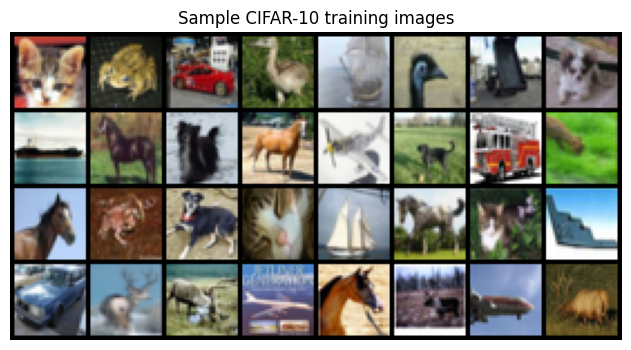

In [1]:
# Your code here
# Step 1 – Load Data 
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# -----------------------------
# Define transforms
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

# -----------------------------
# Load datasets dynamically
# -----------------------------
train_dataset = datasets.CIFAR10(
    root="./data",       
    train=True,
    download=True,       
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# -----------------------------
# Create DataLoaders
# -----------------------------
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# -----------------------------
# Visualize a few sample images
# -----------------------------
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
    std=[1/s for s in [0.2470, 0.2435, 0.2616]]
)

def show_batch(images, title=None):
    imgs = inv_normalize(images)
    grid = make_grid(imgs[:32], nrow=8)   
    npImage = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npImage)
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, title="Sample CIFAR-10 training images")


## Step 2 - Define Training Pipeline

Define a training pipeline like those we have seen in class. Define the class which specifies our neural network architecture, and to define the functions which allow us to train it. We have seen examples of this before, both in class and prior assignments.

Be sure to chose an architecture with sufficient capacity to learn the dataset you have chosen in step #1.

Tip: if you see your architecture is insufficient to learn the dataset you have chosen when you run step 3, you may need to return to step #2 to make your architecture wider or deeper.

In [2]:
# Your code here
# Step 2 – Define Training Pipeline
# --------------------------------------------------------
# This section defines:
# 1. A convolutional neural network (CNN) architecture
# 2. Functions to train the model and evaluate accuracy/loss
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# -----------------------------
# Define CNN architecture
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # input: 3x32x32 -> output: 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # output: 32x16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # output: 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # output: 64x8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # output: 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))                  # output: 128x1x1
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# -----------------------------
# Define helper functions
# -----------------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, test_loader, device, epochs=15, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        
    return history


# -----------------------------
# Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate model
model = SimpleCNN(num_classes=10).to(device)
print(model)

Using device: cpu
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU(in

## Step 3 - Train a Model

Kick off your training run here. Be sure to print or plot the error wrt. number of epochs so you can see if your model is learning.


Epoch 01/10 | Train Loss: 1.7606, Train Acc: 0.3315 | Test Loss: 1.6596, Test Acc: 0.3883
Epoch 02/10 | Train Loss: 1.4245, Train Acc: 0.4747 | Test Loss: 1.3098, Test Acc: 0.5108
Epoch 03/10 | Train Loss: 1.2830, Train Acc: 0.5337 | Test Loss: 1.3570, Test Acc: 0.5087
Epoch 04/10 | Train Loss: 1.1944, Train Acc: 0.5690 | Test Loss: 1.1184, Test Acc: 0.5889
Epoch 05/10 | Train Loss: 1.1107, Train Acc: 0.6033 | Test Loss: 1.2272, Test Acc: 0.5686
Epoch 06/10 | Train Loss: 1.0500, Train Acc: 0.6247 | Test Loss: 1.0417, Test Acc: 0.6200
Epoch 07/10 | Train Loss: 1.0075, Train Acc: 0.6425 | Test Loss: 1.0911, Test Acc: 0.6030
Epoch 08/10 | Train Loss: 0.9682, Train Acc: 0.6567 | Test Loss: 0.9780, Test Acc: 0.6461
Epoch 09/10 | Train Loss: 0.9278, Train Acc: 0.6746 | Test Loss: 1.0154, Test Acc: 0.6403
Epoch 10/10 | Train Loss: 0.8940, Train Acc: 0.6840 | Test Loss: 0.8675, Test Acc: 0.6831


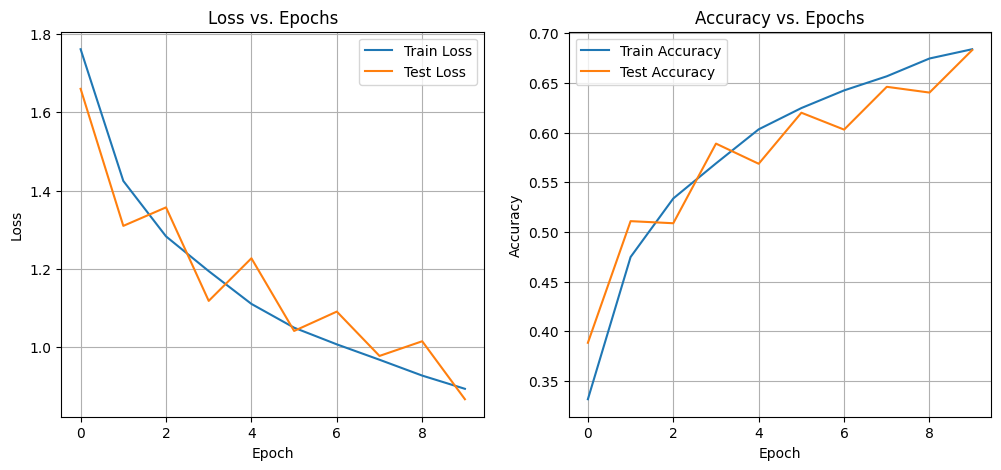

In [3]:
# Your code here
# Step 3 – Train a Model
# --------------------------------------------------------
# This cell trains the CNN defined in Step 2 on the dataset from Step 1.
# It also plots training vs validation (test) loss and accuracy curves.
# --------------------------------------------------------

import matplotlib.pyplot as plt

# Hyperparameters
epochs = 10          # You can increase for better accuracy
learning_rate = 0.01

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=epochs,
    lr=learning_rate
)

# --------------------------------------------------------
# Plot training curves
# --------------------------------------------------------

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## Step 4 - Use Transforms to Robustness Test the Model Against Image Blur

Use the cell below (or add more cells), to write code which repeatedly (e.g., in a for-loop) infers your model on your test set. Each time you do so, apply a blur transform with an increasing amount of blur. Compute and save the average accuracy across the entire test set and then plot the accuracy against the degree of blur (choose and appropriate metric for the degree of blur). The end result of this step should be a plot of accuracy with respect to degree of blur. Be sure to test the model **to failure** to fully characterize its limitations.


Blur σ=0: 100%|██████████| 157/157 [00:03<00:00, 43.85it/s]


Blur σ=0: Accuracy = 0.6831


Blur σ=1: 100%|██████████| 157/157 [00:07<00:00, 20.23it/s]


Blur σ=1: Accuracy = 0.3420


Blur σ=2: 100%|██████████| 157/157 [00:07<00:00, 20.42it/s]


Blur σ=2: Accuracy = 0.2822


Blur σ=3: 100%|██████████| 157/157 [00:07<00:00, 20.66it/s]


Blur σ=3: Accuracy = 0.2753


Blur σ=4: 100%|██████████| 157/157 [00:07<00:00, 20.06it/s]


Blur σ=4: Accuracy = 0.2744


Blur σ=5: 100%|██████████| 157/157 [00:07<00:00, 20.58it/s]


Blur σ=5: Accuracy = 0.2733


Blur σ=6: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s]


Blur σ=6: Accuracy = 0.2729


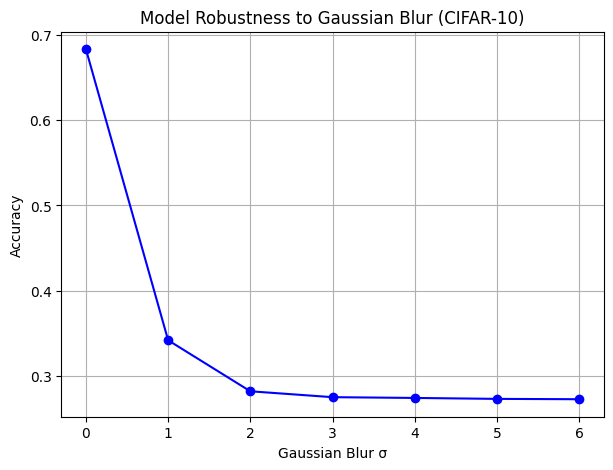

In [4]:
# Your code here
# Step 4 – Robustness Test Against Blur
# --------------------------------------------------------
# Evaluates how model accuracy changes with increasing Gaussian blur.
# --------------------------------------------------------

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Make sure these exist:
# model = ...
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

blur_levels = [0, 1, 2, 3, 4, 5, 6]
accuracies = []

model.eval()
with torch.no_grad():
    for blur_sigma in blur_levels:
        # ✅ Skip GaussianBlur for sigma=0 (no blur)
        if blur_sigma > 0:
            blur_transform = transforms.Compose([
                transforms.GaussianBlur(kernel_size=5, sigma=float(blur_sigma)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
            ])
        else:
            # No blur (identity transform)
            blur_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2470, 0.2435, 0.2616])
            ])

        # Create blurred dataset
        blurred_test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=False, transform=blur_transform
        )
        blurred_test_loader = torch.utils.data.DataLoader(
            blurred_test_dataset, batch_size=64, shuffle=False
        )

        # Compute accuracy
        correct, total = 0, 0
        for images, labels in tqdm(blurred_test_loader, desc=f"Blur σ={blur_sigma}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"Blur σ={blur_sigma}: Accuracy = {accuracy:.4f}")

# --------------------------------------------------------
# Plot results
# --------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.plot(blur_levels, accuracies, marker="o", linestyle="-", color="b")
plt.title("Model Robustness to Gaussian Blur (CIFAR-10)")
plt.xlabel("Gaussian Blur σ")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


## Step 5 - Robustness Test the Model Against a Transform of Your Choice

Repeat step 4 for a transform of your choice. Create a plot showing how model accuracy degrades as the transform is applied more drastically.


Rotation=0°: 100%|██████████| 157/157 [00:03<00:00, 40.45it/s]


Rotation 0°: Accuracy = 0.6831


Rotation=10°: 100%|██████████| 157/157 [00:04<00:00, 38.25it/s]


Rotation 10°: Accuracy = 0.5747


Rotation=20°: 100%|██████████| 157/157 [00:04<00:00, 39.22it/s]


Rotation 20°: Accuracy = 0.3636


Rotation=30°: 100%|██████████| 157/157 [00:04<00:00, 38.71it/s]


Rotation 30°: Accuracy = 0.2876


Rotation=40°: 100%|██████████| 157/157 [00:04<00:00, 38.08it/s]


Rotation 40°: Accuracy = 0.2677


Rotation=50°: 100%|██████████| 157/157 [00:04<00:00, 39.12it/s]


Rotation 50°: Accuracy = 0.2528


Rotation=60°: 100%|██████████| 157/157 [00:03<00:00, 39.51it/s]


Rotation 60°: Accuracy = 0.2289


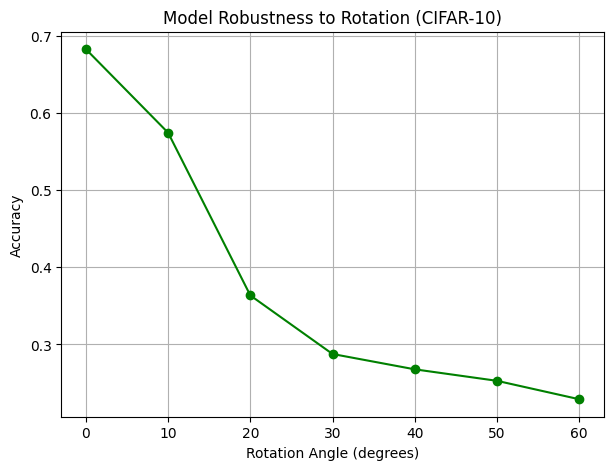

In [5]:

# Step 5 – Robustness Test Against Rotation
# --------------------------------------------------------
# Evaluate how model accuracy changes as test images are rotated.
# --------------------------------------------------------

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Make sure model & device are defined
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Define rotation angles to test (degrees)
rotation_angles = [0, 10, 20, 30, 40, 50, 60]
accuracies_rotation = []

model.eval()
with torch.no_grad():
    for angle in rotation_angles:
        # Apply rotation transform
        rotation_transform = transforms.Compose([
            transforms.RandomRotation((angle, angle)),  # fixed rotation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2470, 0.2435, 0.2616])
        ])

        # Load test dataset with this transform
        rotated_test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=False, transform=rotation_transform
        )
        rotated_test_loader = torch.utils.data.DataLoader(
            rotated_test_dataset, batch_size=64, shuffle=False
        )

        # Compute accuracy
        correct, total = 0, 0
        for images, labels in tqdm(rotated_test_loader, desc=f"Rotation={angle}°"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        accuracies_rotation.append(accuracy)
        print(f"Rotation {angle}°: Accuracy = {accuracy:.4f}")

# --------------------------------------------------------
# Plot results
# --------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.plot(rotation_angles, accuracies_rotation, marker="o", linestyle="-", color="g")
plt.title("Model Robustness to Rotation (CIFAR-10)")
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
